# A) Arena gameplay

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G_erdos = nx.erdos_renyi_graph(1000, 0.002)
G_barabasi = nx.barabasi_albert_graph(1000, 1)

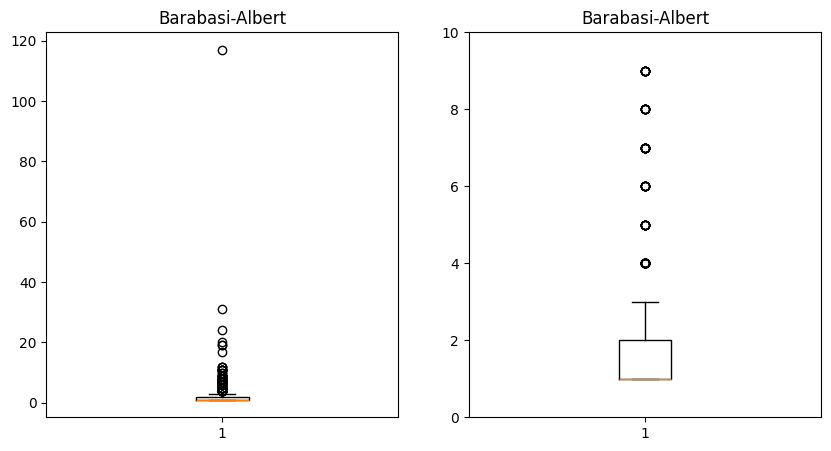

In [35]:
degree_sequence = [d for n, d in G_barabasi.degree()]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.boxplot(degree_sequence)
plt.title('Barabasi-Albert')

degree_sequence = [d for d in degree_sequence if d < 10]
plt.subplot(122)
plt.boxplot(degree_sequence)
plt.ylim(0, 10)
plt.title('Barabasi-Albert')

plt.show()

In [36]:
giant_component_size = max(len(c) for c in nx.connected_components(G_barabasi))
giant_component_size

1000

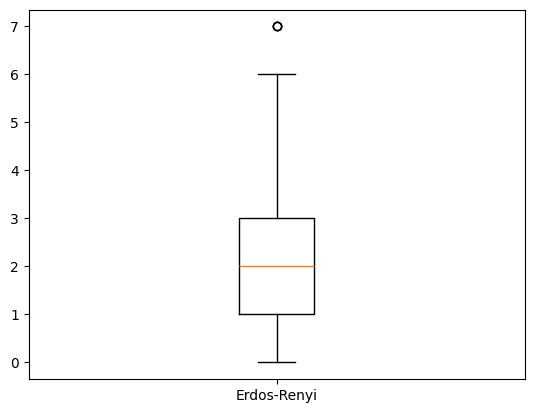

In [21]:
degree_sequence = [d for n, d in G_erdos.degree()]
plt.boxplot([degree_sequence], labels=['Erdos-Renyi'])
plt.show()

In [2]:
import numpy as np

def initialize_sand(G):
    G_degree = dict(G.degree())

    value_dict = {}
    for key, value in G_degree.items():
        if value == 0:
            value_dict[key] = 0
        else:
            random_value = np.random.randint(0, value)
            value_dict[key] = random_value
    
    nx.set_node_attributes(G, value_dict, 'sand')
    return

In [3]:
initialize_sand(G_erdos)
initialize_sand(G_barabasi)

In [9]:
def drop_sand(G, node, depth, visited_nodes = []):
    sand_count = G.nodes[node]['sand']
    node_degree = G.degree[node]

    if node_degree == 0:
        return depth
    
    if len(visited_nodes) == 4 and visited_nodes[0] == visited_nodes[2] and visited_nodes[1] == visited_nodes[3]:
        return depth
    
    if sand_count < node_degree:
        G.nodes[node]['sand'] += 1
    else:
        neighbors = list(G.neighbors(node))
        G.nodes[node]['sand'] = 1  #maybe is 1
        visited_nodes2 = visited_nodes + [node]
        if len(visited_nodes2) > 4:
            visited_nodes2.pop(0)

        for neighbor in neighbors:
            if np.random.rand() < (1/1000):
                continue
            return drop_sand(G, neighbor, depth + 1, visited_nodes2)
    return depth

In [16]:
G_bueno = G_erdos.copy()

avalanche = []
for i in range(10000):
    random_node = np.random.randint(0, G_bueno.number_of_nodes())
    avalanche.append(drop_sand(G_bueno, random_node, 0))

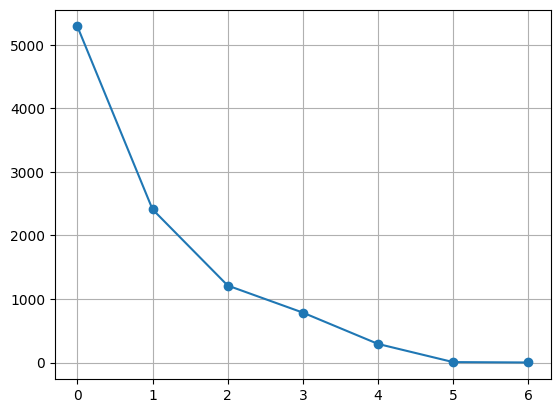

In [17]:
avalanche = np.array(avalanche)
unique, counts = np.unique(avalanche, return_counts=True)

plt.plot(unique, counts, 'o-')
plt.grid()
plt.show()

In [14]:
G_malo = G_barabasi.copy()

avalanche_2 = []
for i in range(10000):
    random_node = np.random.randint(0, G_malo.number_of_nodes())
    avalanche_2.append(drop_sand(G_malo, random_node, 0))

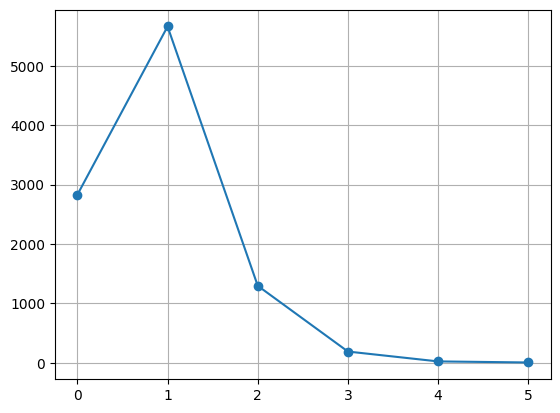

In [15]:
avalanche_2 = np.array(avalanche_2)
unique, counts = np.unique(avalanche_2, return_counts=True)

plt.plot(unique, counts, 'o-')
plt.grid()
plt.show()

# B) Apocalipsis Zombie

En una interaccion zombie-humano:  
* $\alpha$ probabilidad de que el humano se zombifique.  
* $\beta$ probabilidad de que el humano cure al zombie.  
* $1 - \alpha - \beta$ probabilidad de que el humano destruya al zombie.  

Ademas en cada intereraccion el zombie tiene probabilidad $\gamma$ de autodestruirse


$\beta = 0.1$  
Hay que buscar el plano ($\alpha$, $\gamma$)  
Erdos-Renyi, Barabasi, SBM(50 com).  
5000 Nodos, 4 Grado promedio.  
$\gamma = 0.0005$ recomendado.  

In [18]:
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
def init_rand_states(seed=None, length=5000, p=0.05):
    state = {}
    if seed is not None:
        np.random.seed(seed)

    for x in range(length):
        state_random = np.random.random()
        if state_random < p:
            state[x] = 'zombie'
        else:
            state[x] = 'human'
    return state

def calculate_state(G):
    human, zombie, dead = 0, 0, 0
    
    for _, d in G.nodes(data=True):
        if d['state'] == 'human':
            human += 1
        elif d['state'] == 'zombie':
            zombie += 1
        else:
            dead += 1

    return human, zombie, dead

def move_element(d, element, source_key, target_key):
    d[target_key].append(element)
    d[source_key].remove(element)
    return

def simulate_zombie_apocalypse(G, alpha, beta, gamma, n_sim):
    progress_bar = tqdm(
            range(int(1e4)),
            desc=f"Simulacion {n_sim}"
            )

    human_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'human']
    zombie_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'zombie']

    nodes_status = {}
    nodes_status['human'] = human_nodes
    nodes_status['zombie'] = zombie_nodes
    nodes_status['dead'] = []

    # convert to function
    for i in progress_bar:

        if len(nodes_status['human']) == 0 or len(nodes_status['zombie']) == 0:
            print(f'Quedo la caga en la iteracion: {i}')
            break

        for zombie_node in nodes_status['zombie']:
            random_gamma = np.random.random()
            if random_gamma < gamma:
                G.nodes[zombie_node]['state'] = 'dead'
                move_element(nodes_status, zombie_node, 'zombie', 'dead')
                continue

        random_human_node = np.random.choice(nodes_status['human'])
        zombie_neighbors = [n for n in G.neighbors(random_human_node) if G.nodes[n]['state'] == 'zombie']
        if len(zombie_neighbors) > 0:
            interaction_zombie = np.random.choice(zombie_neighbors)

            random_p = np.random.random()
            if random_p < alpha: # zombie wins
                G.nodes[random_human_node]['state'] = 'zombie'
                move_element(nodes_status, random_human_node, 'human', 'zombie')
            elif random_p < alpha + beta: # human cure zombie
                G.nodes[interaction_zombie]['state'] = 'human'
                move_element(nodes_status, interaction_zombie, 'zombie', 'human')
            else: # human wins
                G.nodes[interaction_zombie]['state'] = 'dead'
                move_element(nodes_status, interaction_zombie, 'zombie', 'dead')

        progress_bar.set_postfix(
            human=len(nodes_status['human']),
            zombie=len(nodes_status['zombie']),
            dead=len(nodes_status['dead'])
        )
    return G

Number of nodes: 5000
Number of edges: 10641
Average degree: 4.2564


In [83]:
SEED = 0
BETA = 0.1

G_erdos = nx.erdos_renyi_graph(5000, 0.0008, seed=SEED)
G_barabasi = nx.barabasi_albert_graph(5000, 2, seed=SEED)

num_communities = 50
nodes_per_community = 100
p_intra = 0.0035  # Probability of connection within the same community
p_inter = 0.0008  # Probability of connection between different communities

sizes = [nodes_per_community] * num_communities

p_matrix = np.full((num_communities, num_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G_sbm = nx.stochastic_block_model(sizes, p_matrix, seed=SEED)

average_degree = sum(dict(G_sbm.degree()).values()) / G_sbm.number_of_nodes()
print(f"SBM Number of nodes: {G_sbm.number_of_nodes()}")
print(f"SBM Number of edges: {G_sbm.number_of_edges()}")
print(f"SBM Average degree: {average_degree}")

state = init_rand_states(seed=SEED, length=5000, p=0.05)

nx.set_node_attributes(G_erdos, state, 'state')
nx.set_node_attributes(G_barabasi, state, 'state')
nx.set_node_attributes(G_sbm, state, 'state')

SBM Number of nodes: 5000
SBM Number of edges: 10641
SBM Average degree: 4.2564


In [84]:
alpha_space = [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
gamma_space = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]

# save results
results = []

# Make grid search
for alpha in alpha_space:
    for gamma in gamma_space:
        G = G_sbm.copy()
        G = simulate_zombie_apocalypse(G, alpha, BETA, gamma, 1)

        human, zombie, dead = calculate_state(G)
        print(f'Alpha: {alpha}, Gamma: {gamma}, Human: {human}, Zombie: {zombie}, Dead: {dead}')

        # Save results
        results.append({
            'alpha': alpha,
            'gamma': gamma,
            'human': human,
            'zombie': zombie,
            'dead': dead
        })

Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-08, Human: 4429, Zombie: 132, Dead: 439


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-08, Human: 4445, Zombie: 141, Dead: 414


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-07, Human: 4408, Zombie: 159, Dead: 433


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-07, Human: 4400, Zombie: 141, Dead: 459


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-06, Human: 4286, Zombie: 226, Dead: 488


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-06, Human: 4373, Zombie: 161, Dead: 466


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 1e-05, Human: 4456, Zombie: 130, Dead: 414


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 5e-05, Human: 4427, Zombie: 100, Dead: 473


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.45, Gamma: 0.0001, Human: 4510, Zombie: 54, Dead: 436


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Quedo la caga en la iteracion: 9347
Alpha: 0.45, Gamma: 0.0005, Human: 4630, Zombie: 0, Dead: 370


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-08, Human: 4203, Zombie: 272, Dead: 525


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-08, Human: 4285, Zombie: 234, Dead: 481


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-07, Human: 4190, Zombie: 263, Dead: 547


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-07, Human: 4304, Zombie: 227, Dead: 469


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-06, Human: 4168, Zombie: 283, Dead: 549


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-06, Human: 4162, Zombie: 300, Dead: 538


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 1e-05, Human: 4299, Zombie: 200, Dead: 501


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 5e-05, Human: 4395, Zombie: 135, Dead: 470


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 0.0001, Human: 4477, Zombie: 84, Dead: 439


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.5, Gamma: 0.0005, Human: 4580, Zombie: 2, Dead: 418


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-08, Human: 3860, Zombie: 533, Dead: 607


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-08, Human: 4060, Zombie: 393, Dead: 547


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-07, Human: 4072, Zombie: 367, Dead: 561


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-07, Human: 4072, Zombie: 382, Dead: 546


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-06, Human: 4020, Zombie: 405, Dead: 575


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-06, Human: 3965, Zombie: 426, Dead: 609


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 1e-05, Human: 4106, Zombie: 351, Dead: 543


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 5e-05, Human: 4100, Zombie: 266, Dead: 634


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 0.0001, Human: 4170, Zombie: 200, Dead: 630


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.55, Gamma: 0.0005, Human: 4589, Zombie: 1, Dead: 410


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-08, Human: 3738, Zombie: 621, Dead: 641


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-08, Human: 3733, Zombie: 663, Dead: 604


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-07, Human: 3663, Zombie: 655, Dead: 682


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-07, Human: 3534, Zombie: 781, Dead: 685


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-06, Human: 3375, Zombie: 914, Dead: 711


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-06, Human: 3735, Zombie: 638, Dead: 627


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 1e-05, Human: 3757, Zombie: 598, Dead: 645


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 5e-05, Human: 3878, Zombie: 416, Dead: 706


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 0.0001, Human: 3955, Zombie: 307, Dead: 738


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.6, Gamma: 0.0005, Human: 4559, Zombie: 3, Dead: 438


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-08, Human: 3123, Zombie: 1186, Dead: 691


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-08, Human: 3160, Zombie: 1098, Dead: 742


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-07, Human: 2906, Zombie: 1308, Dead: 786


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-07, Human: 3145, Zombie: 1118, Dead: 737


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-06, Human: 3144, Zombie: 1114, Dead: 742


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-06, Human: 3260, Zombie: 955, Dead: 785


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 1e-05, Human: 3106, Zombie: 1090, Dead: 804


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 5e-05, Human: 3564, Zombie: 683, Dead: 753


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 0.0001, Human: 3553, Zombie: 491, Dead: 956


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.65, Gamma: 0.0005, Human: 4473, Zombie: 13, Dead: 514


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-08, Human: 2353, Zombie: 1883, Dead: 764


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-08, Human: 2351, Zombie: 1899, Dead: 750


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-07, Human: 2722, Zombie: 1594, Dead: 684


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-07, Human: 2734, Zombie: 1569, Dead: 697


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-06, Human: 2657, Zombie: 1650, Dead: 693


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-06, Human: 2822, Zombie: 1457, Dead: 721


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 1e-05, Human: 2689, Zombie: 1550, Dead: 761


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 5e-05, Human: 2781, Zombie: 1213, Dead: 1006


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 0.0001, Human: 3271, Zombie: 688, Dead: 1041


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.7, Gamma: 0.0005, Human: 4370, Zombie: 22, Dead: 608


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-08, Human: 1763, Zombie: 2609, Dead: 628


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-08, Human: 1715, Zombie: 2579, Dead: 706


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-07, Human: 1821, Zombie: 2497, Dead: 682


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-07, Human: 1977, Zombie: 2340, Dead: 683


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-06, Human: 1653, Zombie: 2610, Dead: 737


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-06, Human: 1972, Zombie: 2341, Dead: 687


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 1e-05, Human: 2095, Zombie: 2173, Dead: 732


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 5e-05, Human: 2299, Zombie: 1715, Dead: 986


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 0.0001, Human: 2756, Zombie: 1149, Dead: 1095


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.75, Gamma: 0.0005, Human: 4313, Zombie: 16, Dead: 671


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-08, Human: 1095, Zombie: 3381, Dead: 524


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-08, Human: 1353, Zombie: 3143, Dead: 504


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-07, Human: 1213, Zombie: 3256, Dead: 531


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-07, Human: 1331, Zombie: 3155, Dead: 514


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-06, Human: 1179, Zombie: 3293, Dead: 528


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-06, Human: 1037, Zombie: 3362, Dead: 601


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 1e-05, Human: 1283, Zombie: 3073, Dead: 644


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 5e-05, Human: 1419, Zombie: 2527, Dead: 1054


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 0.0001, Human: 2183, Zombie: 1606, Dead: 1211


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.8, Gamma: 0.0005, Human: 4105, Zombie: 54, Dead: 841


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-08, Human: 526, Zombie: 4182, Dead: 292


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-08, Human: 387, Zombie: 4308, Dead: 305


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-07, Human: 231, Zombie: 4488, Dead: 281


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-07, Human: 569, Zombie: 4168, Dead: 263


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-06, Human: 361, Zombie: 4314, Dead: 325


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-06, Human: 515, Zombie: 4130, Dead: 355


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 1e-05, Human: 574, Zombie: 3934, Dead: 492


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 5e-05, Human: 1005, Zombie: 2978, Dead: 1017


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 0.0001, Human: 1352, Zombie: 2310, Dead: 1338


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.85, Gamma: 0.0005, Human: 3870, Zombie: 126, Dead: 1004


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-08, Human: 71, Zombie: 4929, Dead: 0


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-08, Human: 73, Zombie: 4925, Dead: 2


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-07, Human: 71, Zombie: 4926, Dead: 3


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-07, Human: 71, Zombie: 4913, Dead: 16


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-06, Human: 72, Zombie: 4909, Dead: 19


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-06, Human: 87, Zombie: 4811, Dead: 102


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 1e-05, Human: 147, Zombie: 4649, Dead: 204


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 5e-05, Human: 200, Zombie: 3866, Dead: 934


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 0.0001, Human: 771, Zombie: 2870, Dead: 1359


Simulacion 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha: 0.9, Gamma: 0.0005, Human: 3915, Zombie: 127, Dead: 958


In [85]:
data = pd.DataFrame(results)
data['human_ratio'] = data['human'] / 5000
data.to_csv('sim1_sbm_s0.csv', index=False)

In [86]:
data = pd.read_csv('sim1_sbm_s0.csv')

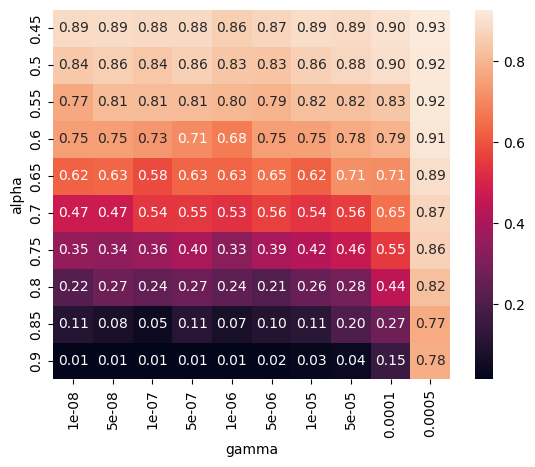

In [87]:
# Make Heatmap with alpha, gamma and human ratio
import seaborn as sns

data_pivot = data.pivot(index='alpha', columns='gamma', values='human_ratio')
sns.heatmap(data_pivot, annot=True, fmt=".2f")
plt.show()